In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import T5ForConditionalGeneration, T5Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

c:\Users\dplg4\OneDrive\Escritorio\train_100K\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [19]:
# Cargar el modelo de embeddings
# model = SentenceTransformer('all-MiniLM-L6-v2')

# Cargar datos 
train_data_embed = pd.read_csv('train_data_embed.csv')
test_data_embed = pd.read_csv('test_data_embed.csv')  


In [42]:
test_data_met1_embed = pd.read_csv('test_data_met1_embed.csv')  

In [20]:
train_data_embed = train_data_embed[train_data_embed['Embeddings'] != "embedding_error"]

# Método 2 de evaluación

In [21]:
train_data_embed['QuestionTags'] = train_data_embed['QuestionTags'].apply(eval)  # Si las etiquetas son cadenas, convertir a listas
test_data_embed['QuestionTags'] = test_data_embed['QuestionTags'].apply(eval)  # Hacer lo mismo para test_data

In [43]:
test_data_met1_embed['QuestionTags'] = test_data_met1_embed['QuestionTags'].apply(eval)  # Hacer lo mismo para test_data

In [32]:
import ast
test_data_embed['Embeddings'] = test_data_embed['Embeddings'].apply(ast.literal_eval)
train_data_embed['Embeddings'] = train_data_embed['Embeddings'].apply(ast.literal_eval)

In [44]:
test_data_met1_embed['Embeddings'] = test_data_met1_embed['Embeddings'].apply(ast.literal_eval)

In [39]:
# Inicializar variables para contar aciertos
aciertos_met2 = 0
total_preguntas_met2 = len(test_data_embed)

# Función para encontrar preguntas similares
def find_similar_questions(query_embedding, train_embeddings, top_k=10):
    similarities = cosine_similarity([query_embedding], train_embeddings)
    similar_indices = np.argsort(-similarities[0])[:top_k]
    return similar_indices


# Función para verificar intersección de etiquetas
def tags_intersect(tags1, tags2):
    return len(set(tags1) & set(tags2)) > 0

# Procesar cada pregunta nueva
for index, row in test_data_embed.iterrows():
    query_embedding = row['Embeddings']
    question_tags = row['QuestionTags']
    answer_owner_id = row['AnswerOwnerUserId']
    
    # Filtrar preguntas de entrenamiento por `question_tag`
    filtered_train_data = train_data_embed[train_data_embed['QuestionTags'].apply(lambda x: tags_intersect(x, question_tags))]
    
    if filtered_train_data.empty:
        continue  # Si no hay coincidencias, saltar al siguiente
    
    # Obtener embeddings de entrenamiento filtrados
    train_data_embeddings = np.array(filtered_train_data['Embeddings'].tolist())
    
    # Encontrar las 10 preguntas históricas más similares
    similar_question_indices = find_similar_questions(query_embedding, train_data_embeddings, top_k=10)
    
    # Obtener `AnswerOwnerId` y preguntas similares
    similar_questions = filtered_train_data.iloc[similar_question_indices][['QuestionText', 'QuestionTags', 'AnswerOwnerUserId']]
    
    # Eliminar duplicados y mantener la pregunta con menor distancia
    unique_answers = {}
    for i, row in similar_questions.iterrows():
        owner_id = row['AnswerOwnerUserId']
        if owner_id not in unique_answers:
            unique_answers[owner_id] = (row['QuestionText'], row['AnswerOwnerUserId'], row['QuestionTags'])
    
    # Validar si el `AnswerOwnerId` original está en los IDs similares
    if answer_owner_id in unique_answers:
        aciertos_met2 += 1

# Calcular la tasa de aciertos
tasa_aciertos_met2 = aciertos_met2 / total_preguntas_met2

print(f"Tasa de aciertos: {tasa_aciertos_met2 * 100:.2f}%")

Tasa de aciertos: 22.24%


In [41]:
print(f"Total de aciertos: {aciertos_met2:.2f}")

Total de aciertos: 5560.00%


# Método 1 de evaluación

In [69]:
# Inicializar variables para contar aciertos
aciertos_met1 = 0
total_preguntas_met1 = len(test_data_met1_embed)
distancias = []

# Función para encontrar preguntas similares
def find_similar_questions(query_embedding, train_embeddings, top_k=10):
    similarities = cosine_similarity([query_embedding], train_embeddings)
    distancias.append(similarities)
    similar_indices = np.argsort(-similarities[0])[:top_k]
    return similar_indices


# Función para verificar intersección de etiquetas
def tags_intersect(tags1, tags2):
    return len(set(tags1) & set(tags2)) > 0

# Procesar cada pregunta nueva
for index, row in test_data_met1_embed.iterrows():
    query_embedding = row['Embeddings']
    question_tags = row['QuestionTags']
    answer_owner_id = row['AnswerOwnerUserId']
    
    # Filtrar preguntas de entrenamiento por `question_tag`
    filtered_train_data = train_data_embed[train_data_embed['QuestionTags'].apply(lambda x: tags_intersect(x, question_tags))]
    
    if filtered_train_data.empty:
        continue  # Si no hay coincidencias, saltar al siguiente
    
    # Obtener embeddings de entrenamiento filtrados
    train_data_embeddings = np.array(filtered_train_data['Embeddings'].tolist())
    
    # Encontrar las 10 preguntas históricas más similares
    similar_question_indices = find_similar_questions(query_embedding, train_data_embeddings, top_k=10)
    
    # Obtener `AnswerOwnerId` y preguntas similares
    similar_questions = filtered_train_data.iloc[similar_question_indices][['QuestionText', 'QuestionTags', 'AnswerOwnerUserId']]
    
    # Eliminar duplicados y mantener la pregunta con menor distancia
    unique_answers = {}
    for i, row in similar_questions.iterrows():
        owner_id = row['AnswerOwnerUserId']
        if owner_id not in unique_answers:
            unique_answers[owner_id] = (row['QuestionText'], row['AnswerOwnerUserId'], row['QuestionTags'])
    
    # Validar si el `AnswerOwnerId` original está en los IDs similares
    if answer_owner_id in unique_answers:
        aciertos_met1 += 1

# Calcular la tasa de aciertos
tasa_aciertos_met1 = aciertos_met1 / total_preguntas_met1

print(f"Tasa de aciertos: {tasa_aciertos_met1 * 100:.2f}%")

In [ ]:
distancias

[array([[ 0.03938659,  0.04616159,  0.11930356, ..., -0.00536235,
          0.12874075, -0.01209202]]),
 array([[0.18303594, 0.37939024, 0.25349827, ..., 0.08270425, 0.09766597,
         0.10419429]]),
 array([[ 0.10191226, -0.01880081, -0.08538551, ...,  0.03774578,
         -0.06185036,  0.09445655]]),
 array([[0.15798579, 0.16862251, 0.13068441, ..., 0.11441016, 0.42801304,
         0.31156355]]),
 array([[ 0.15785982,  0.23166372, -0.01616525, ...,  0.42549368,
          0.00344276,  0.13757304]]),
 array([[0.20652059, 0.15247513, 0.26065978, ..., 0.33884098, 0.18636663,
         0.14459843]]),
 array([[ 0.11621565,  0.16245024,  0.16355709, ...,  0.15385904,
          0.04781127, -0.03476071]]),
 array([[ 0.16091247, -0.0566772 , -0.02427594, ...,  0.11153726,
         -0.04280595,  0.05665145]]),
 array([[0.26398649, 0.13574204, 0.27331637, ..., 0.34562151, 0.27728494,
         0.22703681]]),
 array([[0.22799463, 0.16304851, 0.14856486, ..., 0.21983167, 0.05831071,
         0.161

In [ ]:
print(f"Total de aciertos: {aciertos_met1:.2f}")

Total de aciertos: 1000.00%



Sample 1 - Pregunta Original: Show all triggers in a MySQL database What is the command to list all triggers in a MySQL database?


Sample 1 - Pregunta parafraseada: Display all triggers stored in a MySQL database. What is the query to view all triggers in a MySQL database?

Sample 1 - Usuario resolutor: 4704
  Pregunta 1: Show all triggers in a MySQL database What is the command to list all triggers in a MySQL database?
 (Distancia: 1.00) (Resolutor: 4704)
  Pregunta 2: How do you identify the triggers associated with a table in a sybase database? I am using SQL Advantage and need to know what the SQL is to identify the triggers associated with a table.  I don't have the option to use another tool so the good old fashioned SQL solution is the ideal answer.
 (Distancia: 0.62) (Resolutor: 7329)
  Pregunta 3: How to get list of tables without any active triggers? I have database in SQL Server 2008 with triggers on almost every table. I need to review tables without active triggers.
How 

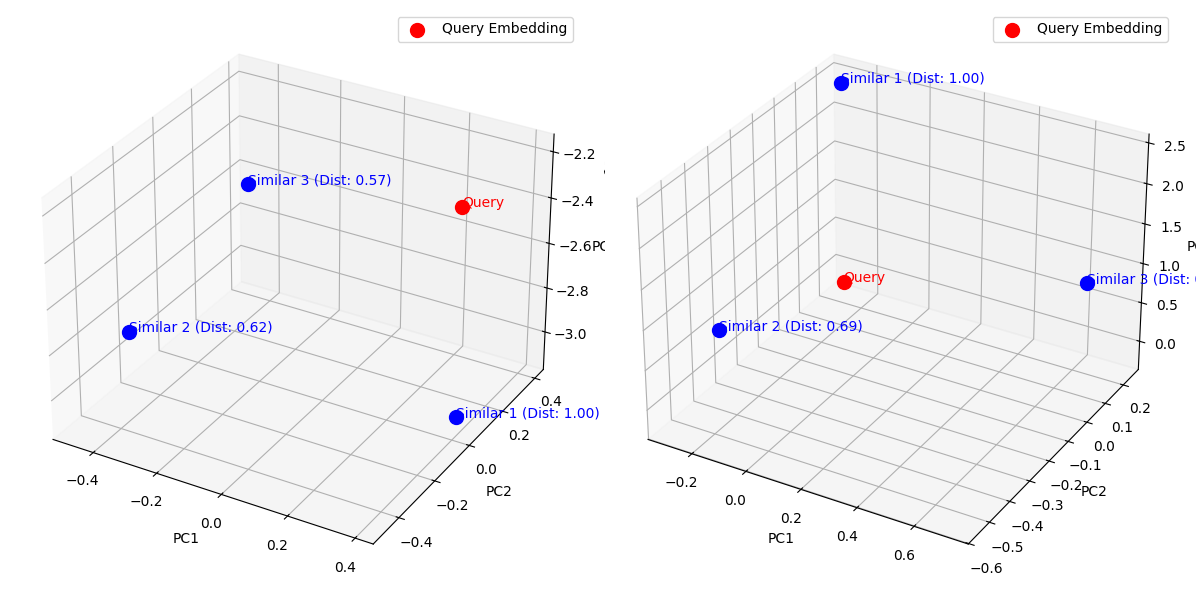

In [ ]:


# Seleccionar una muestra de 2 datos de test_data_met1
sample_indices = [0, 25]
samples = test_data_met1_embed.iloc[sample_indices]

# Función para encontrar preguntas similares
def find_similar_questions(query_embedding, train_embeddings, top_k=10):
    similarities = cosine_similarity([query_embedding], train_embeddings)[0]
    similar_indices = np.argsort(-similarities)[:top_k]
    return similar_indices, similarities[similar_indices]

# Crear gráficas 3D
fig = plt.figure(figsize=(18, 6))

for i, (index, sample) in enumerate(samples.iterrows()):
    query_embedding = sample['Embeddings']
    query_text = sample['QuestionText']
    query_par = sample['paraphrased'] 
    user = sample['AnswerOwnerUserId'] 
    
    # Encontrar las preguntas más similares
    similar_indices, distances = find_similar_questions(query_embedding, np.array(train_data_embed['Embeddings'].tolist()), top_k=3)
    similar_questions = train_data_embed.iloc[similar_indices]
    similar_embeddings = np.array(similar_questions['Embeddings'].tolist())
    
    # Imprimir las preguntas originales y las más similares
    print(f"\nSample {i+1} - Pregunta Original: {query_text}")
    print(f"\nSample {i+1} - Pregunta parafraseada: {query_par}")
    print(f"\nSample {i+1} - Usuario resolutor: {user}")
    for j, (similar_index, distance) in enumerate(zip(similar_indices, distances)):
        paraphrased_text = train_data_embed.iloc[similar_index]['QuestionText']
        resolutor = train_data_embed.iloc[similar_index]['AnswerOwnerUserId']
        print(f"  Pregunta {j+1}: {paraphrased_text} (Distancia: {distance:.2f}) (Resolutor: {resolutor})")
    
    # Combinar los embeddings para PCA
    all_embeddings = np.vstack([query_embedding] + similar_embeddings.tolist())
    pca = PCA(n_components=3)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    
    # Graficar el embedding de la consulta
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1], reduced_embeddings[0, 2], c='r', label='Query Embedding', s=100)
    ax.text(reduced_embeddings[0, 0], reduced_embeddings[0, 1], reduced_embeddings[0, 2], 'Query', color='red')
    
    # Graficar los embeddings similares
    for j in range(1, len(reduced_embeddings)):
        ax.scatter(reduced_embeddings[j, 0], reduced_embeddings[j, 1], reduced_embeddings[j, 2], c='b', s=100)
        ax.text(reduced_embeddings[j, 0], reduced_embeddings[j, 1], reduced_embeddings[j, 2], f'Similar {j} (Dist: {distances[j-1]:.2f})', color='blue')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()

plt.tight_layout()
plt.show()